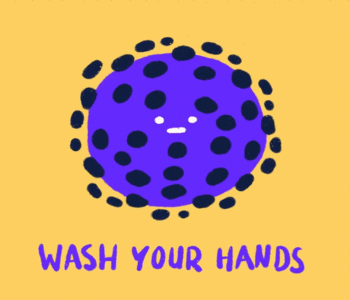

# ***Show Your support by Upvoting this Notebook***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import plotly.express as px
import plotly.graph_objects as go
# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
pd.set_option('precision',0)
#pd.set_option('chop_threshold',8)

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing datasets
full_table = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv', 
                         parse_dates=['ObservationDate'])
pd.set_option('display.max_rows', full_table.shape[0]+1) # To display the whole rows
pd.set_option('display.max_columns', None)
full_table.style.set_properties(subset=['ad_description'], **{'width-max': '100px'})

full_table.tail(10).style.background_gradient(cmap='cool')

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
77457,77458,2020-08-01 00:00:00,Yukon,Canada,2020-08-02 04:34:47,14,0,11
77458,77459,2020-08-01 00:00:00,Yunnan,Mainland China,2020-08-02 04:34:47,191,2,187
77459,77460,2020-08-01 00:00:00,Zabaykalsky Krai,Russia,2020-08-02 04:34:47,4094,47,3749
77460,77461,2020-08-01 00:00:00,Zacatecas,Mexico,2020-08-02 04:34:47,2768,247,1849
77461,77462,2020-08-01 00:00:00,Zakarpattia Oblast,Ukraine,2020-08-02 04:34:47,5210,198,2058
77462,77463,2020-08-01 00:00:00,Zaporizhia Oblast,Ukraine,2020-08-02 04:34:47,800,21,597
77463,77464,2020-08-01 00:00:00,Zeeland,Netherlands,2020-08-02 04:34:47,867,69,0
77464,77465,2020-08-01 00:00:00,Zhejiang,Mainland China,2020-08-02 04:34:47,1270,1,1268
77465,77466,2020-08-01 00:00:00,Zhytomyr Oblast,Ukraine,2020-08-02 04:34:47,1896,37,1485
77466,77467,2020-08-01 00:00:00,Zuid-Holland,Netherlands,2020-08-02 04:34:47,13262,1311,0


In [3]:
#Counting rows with the most number of rows into the Dataset as per Country/Region
full_table['Country/Region'].value_counts().head(20)

US                9282
Mainland China    5981
Russia            5268
Japan             3310
Mexico            2451
Colombia          2310
Canada            2128
Brazil            2102
India             2045
Peru              1799
Italy             1784
Ukraine           1764
UK                1728
Spain             1698
France            1566
Germany           1467
Australia         1380
Sweden            1344
Chile             1336
Netherlands        882
Name: Country/Region, dtype: int64

In [4]:
full_table.isnull().sum()

SNo                    0
ObservationDate        0
Province/State     26449
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

In [5]:
full_table.describe().style.background_gradient(cmap='prism')

,SNo,Confirmed,Deaths,Recovered
count,77467,77467,77467,77467
mean,38734,11807,601,5745
std,22363,35795,2569,32338
min,1,0,0,0
25%,19368,132,1,1
50%,38734,1154,21,167
75%,58100,6198,196,1842
max,77467,552318,41584,1461885


In [6]:

# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

# latest
full_latest = full_table[full_table['ObservationDate'] == max(full_table['ObservationDate'])].reset_index()



### Displaying Top 100 countries with most cases.

In [7]:
# Active Case = confirmed - deaths - recovered
full_latest_grouped = full_latest['Confirmed'] - full_latest['Deaths'] - full_latest['Recovered']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
cm = sns.light_palette("red", as_cmap=True)
temp_f.head(101).style.background_gradient(cmap=cm).background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Wistia',subset=["Active"]).background_gradient(cmap='Blues',subset=["Confirmed"])

,Country/Region,Confirmed,Deaths,Recovered,Active
0,US,4620444,154447,1461885,3004112
1,Brazil,2707877,93563,2037982,576332
2,India,1750723,37364,1145629,567730
3,Russia,843890,14034,645316,184540
4,South Africa,503290,8153,342461,152676
5,Mexico,434193,47472,334867,51854
6,Peru,407492,19021,287127,101344
7,Chile,357658,9533,330507,17618
8,Iran,306752,16982,265830,23940
9,Colombia,306181,10330,160708,135143


### Displaying Cases Date Wise.

In [8]:

#Latest Data
#This creates a table that sums up every element in the Confirmed, Deaths, and recovered columns.
temp = full_table.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
#Reset index coverts the index series, in this case date, into an index value.

temp = temp.sort_values('ObservationDate', ascending=False)
cm = sns.light_palette("red", as_cmap=True)
temp.head(15).style.background_gradient(cmap=cm).background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Wistia',subset=["Active"]).background_gradient(cmap='Blues',subset=["Confirmed"])

,ObservationDate,Confirmed,Deaths,Recovered,Active
192,2020-08-01 00:00:00,17849853,685054,10553585,6611214
191,2020-07-31 00:00:00,17591968,679439,10330958,6581571
190,2020-07-30 00:00:00,17305917,673173,10132582,6500162
189,2020-07-29 00:00:00,17029155,667011,9948163,6413981
188,2020-07-28 00:00:00,16691527,659622,9711187,6320718
187,2020-07-27 00:00:00,16487669,654055,9572619,6260995
186,2020-07-26 00:00:00,16252541,648637,9397505,6206399
185,2020-07-25 00:00:00,16046986,645257,9262520,6139209
184,2020-07-24 00:00:00,15792390,639652,9043203,6109535
183,2020-07-23 00:00:00,15511157,633396,8813886,6063875


In [9]:
                         
temp1 = full_table.groupby('ObservationDate')['Recovered', 'Deaths', 'Active'].sum().reset_index()
temp1 = temp1.melt(id_vars="ObservationDate", value_vars=['Recovered', 'Deaths', 'Active'],
                 var_name='Case', value_name='Count')
print(temp1.head())
# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801'

fig = px.area(temp1, x="ObservationDate", y="Count", color='Case', height=600,
             title='Cases over time', color_discrete_sequence = [rec, dth, act])
fig.show()

  ObservationDate       Case  Count
0      2020-01-22  Recovered     28
1      2020-01-23  Recovered     30
2      2020-01-24  Recovered     36
3      2020-01-25  Recovered     39
4      2020-01-26  Recovered     52


In [10]:
#temp.head(1)[['Confirmed', 'Deaths', 'Recovered']].plot(kind='bar')
tot_count = pd.DataFrame({'Category':'Deaths', 'Count':temp.head(1)['Deaths']})
tot_count = tot_count.append({'Category':'Recovered','Count':int(temp.head(1)['Recovered'])}, ignore_index=True)
tot_count = tot_count.append({'Category':"Confirmed",'Count':int(temp.head(1)['Confirmed'])}, ignore_index=True)
#print(tot_count.head()) #Uncomment this if you want to print the Head values
fig = px.bar(tot_count, x='Count', y='Category',
             hover_data=['Count'], color='Count',
             labels={}, orientation='h',height=400, width = 650)
fig.update_layout(title_text='Total number of Confirmed vs Recovered vs Death cases!!')
fig.show()

# **Comparison with other epidemics**

In [11]:
epidemics = pd.DataFrame({
    'epidemic' : ['COVID-19', 'SARS', 'EBOLA', 'MERS', 'H1N1'],
    'start_year' : [2019, 2003, 2014, 2012, 2009],
    'end_year' : [2020, 2004, 2016, 2017, 2010],
    'confirmed' : [full_latest['Confirmed'].sum(), 8096, 28646, 2494, 6724149],
    'deaths' : [full_latest['Deaths'].sum(), 774, 11323, 858, 19654]
})

epidemics['mortality'] = round((epidemics['deaths']/epidemics['confirmed'])*100, 2)

epidemics.head().style.background_gradient(cmap='terrain')

,epidemic,start_year,end_year,confirmed,deaths,mortality
0,COVID-19,2019,2020,17849853,685054,4
1,SARS,2003,2004,8096,774,10
2,EBOLA,2014,2016,28646,11323,40
3,MERS,2012,2017,2494,858,34
4,H1N1,2009,2010,6724149,19654,0


In [12]:
temp = epidemics.melt(id_vars='epidemic', value_vars=['confirmed', 'deaths', 'mortality'],
                      var_name='Case', value_name='Value')

fig = px.bar(temp, x="epidemic", y="Value", color='epidemic', text='Value', facet_col="Case",
             color_discrete_sequence = px.colors.qualitative.Bold)
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_yaxes(showticklabels=False)
fig.layout.yaxis2.update(matches=None)
fig.layout.yaxis3.update(matches=None)
fig.show()

In [13]:
#No.of Countries  affected with Virus
full_table['Country/Region'].nunique()

223

In [14]:
china_confirmed = full_latest[full_latest['Country/Region']=='China']['Confirmed'].sum()
print("China's Confirmed cases = ",china_confirmed)
total_country_confirmed_cases = full_latest['Confirmed'].sum()
print("Total Confirmed cases of all countries = ",total_country_confirmed_cases)

China's Confirmed cases =  84385.0
Total Confirmed cases of all countries =  17849853.0


In [15]:

outside_mainland_china_confirmed = total_country_confirmed_cases - china_confirmed
x = np.array([china_confirmed,outside_mainland_china_confirmed])
fig = go.Figure(data=[go.Pie(labels=["China","Other Countries"], values=x,hole=0.2)])
fig.update_layout(title_text='Coronavirus Confirmed Cases in China and Other Countries than China')
fig.show()


In [16]:
#Check this link for the below visualization-> https://app.flourish.studio/visualisation/1571387/edit
#Credit - Devakumar Kp
    
from IPython.core.display import HTML
HTML('''<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/1571387"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

In [17]:

dfr1=pd.DataFrame({'Country':temp_f['Country/Region'],'Cases':temp_f['Confirmed'],'Active':temp_f['Active']
                  ,'Recovered':temp_f['Recovered'],'Deaths':temp_f['Deaths']})
dfr1 = dfr1[0:25]
dfr1.style.background_gradient(cmap='Paired_r')
#country = country.index

,Country,Cases,Active,Recovered,Deaths
0,US,4620444,3004112,1461885,154447
1,Brazil,2707877,576332,2037982,93563
2,India,1750723,567730,1145629,37364
3,Russia,843890,184540,645316,14034
4,South Africa,503290,152676,342461,8153
5,Mexico,434193,51854,334867,47472
6,Peru,407492,101344,287127,19021
7,Chile,357658,17618,330507,9533
8,Iran,306752,23940,265830,16982
9,Colombia,306181,135143,160708,10330


In [18]:
#Plotting top 25 countries with most cases.
chart=pd.DataFrame()
chart['Country']=dfr1.Country.sort_index(ascending = False)
chart['Cases']=dfr1.Cases
chart['Active']=dfr1.Active
chart['Recovered']=dfr1.Recovered
chart['Deaths']=dfr1.Deaths

fig = px.bar(chart, x='Cases', y='Country',
             hover_data=['Cases'], color='Cases',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='Total number of Confirmed cases!!')
fig.show()

#Plotting top 25 countries with most Active cases.
fig = px.bar(chart, x='Active', y='Country',
             hover_data=['Active'], color='Active',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='25 countries with most Active cases!!')
fig.show()

#Plotting top 25 countries with most Recovered Cases.
fig = px.bar(chart, x='Recovered', y='Country',
             hover_data=['Recovered'], color='Recovered',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='25 countries with most Recovered Cases!!')
fig.show()

#Plotting top 25 countries with most Deaths.
fig = px.bar(chart, x='Deaths', y='Country',
             hover_data=['Deaths'], color='Deaths',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='25 countries with most Deaths!!')
fig.show()

**Infection rate is high and it is increasing, confirmed cases a lot and recovery is not going fast but death rate is being controlled if this trend continues more people will be affected than being recovered.

**So prevention is better than cure if infection rate can be controlled sooner then it would be easy to help with recovery ,so instructions can be followed as mentioned in the image below to stay safe from novel corona virus****

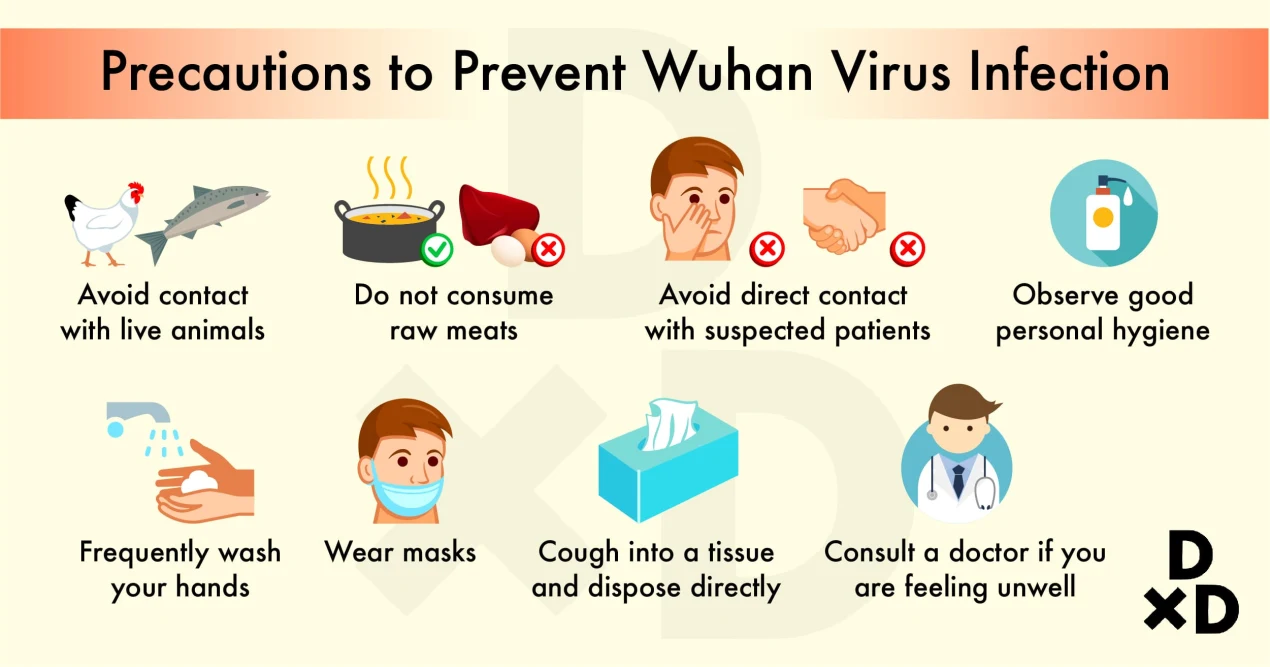